# Convert and extract train and testing data

#### Note:
 The following part is part of the data conversion from 'ogg' sound to '.wav' and from '.wav' to MFCC tensors. This part could be skipped when running the code since it takes several minutes (30 min approx.) and the MFCC tensors are already sent in the folder.

In [2]:
from pathlib import Path
from pydub import AudioSegment
from tqdm import tqdm
import random

base_dir = Path.cwd() 
ogg_root = base_dir / "Data_New"
wav_train_root = base_dir / "Data_New_Wav_Train"
wav_test_root = base_dir / "Data_New_Wav_Test"
wav_train_root.mkdir(parents=True, exist_ok=True)
wav_test_root.mkdir(parents=True, exist_ok=True)

# Process each species subfolder
for species_dir in ogg_root.iterdir():
    if species_dir.is_dir():
        ogg_files = sorted(list(species_dir.glob("*.ogg")))
        
        # Shuffle files to ensure randomness
        random.shuffle(ogg_files)

        # Compute split index
        split_idx = int(len(ogg_files) * 0.8)
        ogg_train = ogg_files[:split_idx]
        ogg_test = ogg_files[split_idx:]

        def convert_batch(batch, output_base):
            for ogg_file in tqdm(batch, desc=f"Converting {species_dir.name} → {output_base.name}", leave=False):
                try:
                    relative_path = ogg_file.relative_to(ogg_root).with_suffix(".wav")
                    output_path = output_base / relative_path
                    output_path.parent.mkdir(parents=True, exist_ok=True)

                    audio = AudioSegment.from_file(ogg_file, format="ogg")
                    audio.export(output_path, format="wav")
                except Exception as e:
                    print(f"Error converting {ogg_file}: {e}")

        # Apply conversion to training and testing sets
        convert_batch(ogg_train, wav_train_root)
        convert_batch(ogg_test, wav_test_root)


KeyboardInterrupt: 

# From .wav to MFCC Tensors

In [2]:
import torchaudio
import torchaudio.transforms as T
import torch
from pathlib import Path
from tqdm import tqdm

# Input directories
wav_train_root = base_dir / "Data_New_Wav_Train"
wav_test_root  = base_dir / "Data_New_Wav_Test"
# Output directories
mfcc_train_root = base_dir / "MFCC_Tensors_Train"
mfcc_test_root  = base_dir / "MFCC_Tensors_Test"

mfcc_train_root.mkdir(parents=True, exist_ok=True)
mfcc_test_root.mkdir(parents=True, exist_ok=True)

# MFCC settings
sample_rate = 16000
n_mfcc = 13
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={"n_fft": 1024, "hop_length": 512, "n_mels": 40}
)

# Function to extract MFCCs from a set
def extract_mfccs(wav_root, mfcc_root, label=""):
    wav_files = list(wav_root.rglob("*.wav"))
    print(f"{label} Found {len(wav_files)} WAV files.")

    for wav_file in tqdm(wav_files, desc=f"Extracting MFCCs ({label})"):
        try:
            waveform, sr = torchaudio.load(wav_file)

            if sr != sample_rate:
                resample = T.Resample(sr, sample_rate)
                waveform = resample(waveform)

            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            mfcc = mfcc_transform(waveform)
            relative_path = wav_file.relative_to(wav_root).with_suffix(".pt")
            save_path = mfcc_root / relative_path
            save_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(mfcc, save_path)

        except Exception as e:
            print(f"Error processing {wav_file}: {e}")

# Run both extractions
extract_mfccs(wav_train_root, mfcc_train_root, label="Train")
extract_mfccs(wav_test_root, mfcc_test_root, label="Test")


Train Found 3515 WAV files.


Extracting MFCCs (Train): 100%|██████████| 3515/3515 [03:13<00:00, 18.12it/s]


Test Found 887 WAV files.


Extracting MFCCs (Test): 100%|██████████| 887/887 [01:00<00:00, 14.54it/s]


# DVAE

In [ ]:
import torch
import torch.nn as nn
from pathlib import Path
from tqdm import tqdm
import random


# DVAE Encoder with Classifier Head

class DVAEEncoder(nn.Module):
    def __init__(self, n_mfcc=13, hidden_size=128, latent_dim=64, num_classes=20):
        super().__init__()
        self.gru = nn.GRU(input_size=n_mfcc, hidden_size=hidden_size, batch_first=True)
        self.mu = nn.Linear(hidden_size, latent_dim)
        self.logvar = nn.Linear(hidden_size, latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )  # classification head

    def forward(self, x):
        _, h = self.gru(x)          # GRU returns final hidden state
        h = h.squeeze(0)            # Remove GRU output batch dimension
        mu = self.mu(h)             # Latent mean
        logvar = self.logvar(h) 
        z = reparameterize(mu, logvar)    # Latent log-variance
        #class_logits = self.classifier(mu)  # Predict class from latent vector
        class_logits = self.classifier(z)
        return mu, logvar, class_logits


# DVAE Decoder

class DVAEDecoder(nn.Module):
    def __init__(self, latent_dim=64, hidden_size=128, output_dim=13, seq_len=100):
        super().__init__()
        self.seq_len = seq_len
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_size)
        self.gru = nn.GRU(input_size=output_dim, hidden_size=hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, output_dim)

    def forward(self, z):
        h0 = self.latent_to_hidden(z).unsqueeze(0)  # Initialize GRU with hidden vector
        decoder_input = torch.zeros((z.size(0), self.seq_len, 13), device=z.device)
        out, _ = self.gru(decoder_input, h0)
        return self.output(out)


# Reparameterization Trick

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


# Supervised DVAE Loss Function

def supervised_dvae_loss(reconstructed, original, mu, logvar, class_logits, labels, beta=5, alpha=100):
    # Align time dimension
    time_dim = reconstructed.shape[1]
    original = original[:, :time_dim, :]

    # Reconstruction Loss (MSE)
    recon_loss = nn.functional.mse_loss(reconstructed, original, reduction='mean')

    # KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / original.size(0)

    # Classification Loss (Cross-Entropy)
    class_loss = nn.functional.cross_entropy(class_logits, labels)

    # Total loss = VAE + Classification (weighted)
    total_loss = 0.1*recon_loss + beta * kl_loss + alpha * class_loss
    return total_loss, recon_loss, kl_loss, class_loss
------

# Load MFCC Batch with Labels

def load_mfcc_batch_with_labels(mfcc_folder, label_to_index, batch_size=16, max_len=100):
    """
    Loads a batch of MFCC tensors and their corresponding labels.
    All files must be organized in subfolders named after their class.
    """
    mfcc_paths = list(Path(mfcc_folder).rglob("*.pt"))   # Find all .pt files recursively
    random.shuffle(mfcc_paths)                            # Shuffle for batch diversity
    batch_paths = mfcc_paths[:batch_size]                 # Select batch

    batch = []    # Holds MFCC sequences
    labels = []   # Holds integer labels

    for path in batch_paths:
        label = path.parent.name                          # Folder name is the class label
        y = label_to_index[label]                         # Map label to index

        mfcc = torch.load(path).squeeze(0).transpose(0, 1)  # Shape: (time, 13)

        # Pad or crop to fixed length
        if mfcc.shape[0] < max_len:
            pad = torch.zeros((max_len - mfcc.shape[0], mfcc.shape[1]))
            mfcc = torch.cat([mfcc, pad], dim=0)
        else:
            mfcc = mfcc[:max_len]

        batch.append(mfcc.unsqueeze(0))                   # Add sample with batch dimension
        labels.append(y)

    # Stack into a single tensor batch
    return torch.cat(batch, dim=0), torch.tensor(labels)

# Train the Supervised DVAE

def train_supervised_dvae(encoder, decoder, mfcc_folder, label_to_index,
                          epochs=300, batch_size=16, max_len=100,
                          alpha=100.0, beta=0.1):
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3
    )

    history = {'total': [], 'recon': [], 'kl': [], 'class': []}

    for epoch in range(1, epochs + 1):
        X_batch, y_batch = load_mfcc_batch_with_labels(mfcc_folder, label_to_index, batch_size, max_len)
        encoder.train(); decoder.train(); optimizer.zero_grad()

        beta = min(1.0, epoch / 100)
        mu, logvar, class_logits = encoder(X_batch)
        z = reparameterize(mu, logvar)
        reconstructed = decoder(z)

        loss, recon, kl, class_loss = supervised_dvae_loss(
            reconstructed, X_batch, mu, logvar, class_logits, y_batch, beta, alpha
        )

        loss.backward(); optimizer.step()

        # Guardar las métricas
        history['total'].append(loss.item())
        history['recon'].append(recon.item())
        history['kl'].append(kl.item())
        history['class'].append(class_loss.item())

        if epoch % 50 == 0 or epoch == 1:
            print(f"[Epoch {epoch}] Total: {loss:.4f} | Recon: {recon:.4f} | KL: {kl:.4f} | Class: {class_loss:.4f}")

    return encoder, decoder, history


## Train DVAE

In [ ]:

# SETUP: Define paths and label mapping


# Path to your training MFCC data (must be organized in subfolders per class)
mfcc_folder = Path.cwd() / "MFCC_Tensors_Train"

# Automatically extract all label names (folder names)
label_names = sorted([d.name for d in Path(mfcc_folder).iterdir() if d.is_dir()])
label_to_index = {label: idx for idx, label in enumerate(label_names)}

print(f"Found {len(label_to_index)} classes.")
print("Label mapping:", label_to_index)


# Initialize the encoder and decoder


encoder = DVAEEncoder(n_mfcc=13, hidden_size=128, latent_dim=64, num_classes=len(label_to_index))
decoder = DVAEDecoder(latent_dim=64, hidden_size=128, output_dim=13, seq_len=100)


# Train the DVAE with supervision


encoder, decoder, history = train_supervised_dvae(
    encoder,
    decoder,
    mfcc_folder=mfcc_folder,
    label_to_index=label_to_index,
    epochs=1000,
    batch_size=16,
    max_len=100,
    alpha=200
)


Found 15 classes.
Label mapping: {'amekes': 0, 'babwar': 1, 'baymac': 2, 'bbwduc': 3, 'bkcdon': 4, 'bkmtou1': 5, 'blbgra1': 6, 'whbman1': 7, 'whfant1': 8, 'whtdov': 9, 'yecspi2': 10, 'yehcar1': 11, 'yeofly1': 12, 'yercac1': 13, 'ywcpar': 14}
[Epoch 1] Total: 683.8799 | Recon: 1396.9884 | KL: 10.5180 | Class: 2.7204
[Epoch 50] Total: 654.5580 | Recon: 976.9940 | KL: 17.0469 | Class: 2.7417
[Epoch 100] Total: 649.5067 | Recon: 929.3277 | KL: 13.1900 | Class: 2.7169
[Epoch 150] Total: 597.5871 | Recon: 788.2021 | KL: 18.0402 | Class: 2.5036
[Epoch 200] Total: 539.2491 | Recon: 501.3462 | KL: 21.4257 | Class: 2.3384
[Epoch 250] Total: 588.5093 | Recon: 666.3485 | KL: 21.2461 | Class: 2.5031
[Epoch 300] Total: 487.5324 | Recon: 512.6257 | KL: 20.3583 | Class: 2.0796
[Epoch 350] Total: 491.4193 | Recon: 402.6819 | KL: 22.1849 | Class: 2.1448
[Epoch 400] Total: 588.4156 | Recon: 465.9925 | KL: 17.6235 | Class: 2.6210
[Epoch 450] Total: 451.8065 | Recon: 371.2151 | KL: 25.0564 | Class: 1.9481


## Extract Latent Vectors from Encoder

In [ ]:

# Extract Latent Vectors from Encoder

def extract_latent_space(encoder, mfcc_folder, label_to_index, max_files_per_class=None, max_len=100):
    """
    Uses the trained encoder to compute latent vectors for each MFCC file.
    """
    encoder.eval()  # Set encoder to evaluation mode
    mfcc_folder = Path(mfcc_folder)

    zs, ys = [], []  # Latent vectors and class indices

    # Sort folders alphabetically to keep consistent mapping
    for class_dir in mfcc_folder.iterdir():
        if not class_dir.is_dir():
            continue

        label = class_dir.name
        if label not in label_to_index:
            continue  # Skip unknown classes

        mfcc_files = list(class_dir.glob("*.pt"))
        if max_files_per_class:
            mfcc_files = mfcc_files[:max_files_per_class]

        for f in tqdm(mfcc_files, desc=f"Encoding {label}", leave=False):
            mfcc = torch.load(f)

            if mfcc.dim() == 3:
                mfcc = mfcc.squeeze(0)

            mfcc = mfcc.transpose(0, 1).unsqueeze(0)  # Shape: [1, time, n_mfcc]

            # Pad or crop to max_len
            if mfcc.shape[1] < max_len:
                pad = torch.zeros((1, max_len - mfcc.shape[1], mfcc.shape[2]))
                mfcc = torch.cat([mfcc, pad], dim=1)
            else:
                mfcc = mfcc[:, :max_len, :]

            # Forward through encoder
            with torch.no_grad():
                mu, _, _ = encoder(mfcc)
                zs.append(mu.squeeze(0))
                ys.append(label_to_index[label])

    return torch.stack(zs), torch.tensor(ys), label_to_index


## Save Models and Latent Space

In [6]:
import pickle
def save_models_and_latents(encoder, decoder, zs, ys, label_to_index, save_dir):
    """
    Saves encoder, decoder weights, and the latent space.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Save model weights
    torch.save(encoder.state_dict(), save_dir / "encoder_weights.pth")
    torch.save(decoder.state_dict(), save_dir / "decoder_weights.pth")

    # Save latent space and label mapping
    latent_data = {
        "zs": zs,
        "ys": ys,
        "label_to_index": label_to_index
    }

    with open(save_dir / "latent_space.pkl", "wb") as f:
        pickle.dump(latent_data, f)

    print("Saved encoder, decoder, and latent space to:", save_dir)


## Extract latent vectors from training set

In [7]:
# Extract latent vectors from training set
zs, ys, label_to_index = extract_latent_space(
    encoder,
    mfcc_folder=mfcc_folder,
    label_to_index=label_to_index,
    max_len=100
)

# Save all components for future use
save_dir = Path.cwd() / "Model"
save_models_and_latents(encoder, decoder, zs, ys, label_to_index, save_dir)


Saved encoder, decoder, and latent space to: c:\Users\camil\Documents\AML_Mini\AML_CAMILO_RAMIREZ\Model


## Latent Vector Preprocessing and Dataset Splitting

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Normalize Latent Vectors

# Normalize latent vectors (zero mean, unit variance)
zs_mean = zs.mean(dim=0)
zs_std = zs.std(dim=0)
zs_normalized = (zs - zs_mean) / zs_std


# Encode labels into integers

le = LabelEncoder()
y_encoded = torch.tensor(le.fit_transform(ys))  # Needed in case labels aren't contiguous


# Train/test split for validation

X_train, X_test, y_train, y_test = train_test_split(
    zs_normalized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


## Visualizing the Latent Space with t-SNE

Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 3515 ticks ([0, ..., 3514]), which exceeds Locator.MAXTICKS (1000).
Locator at

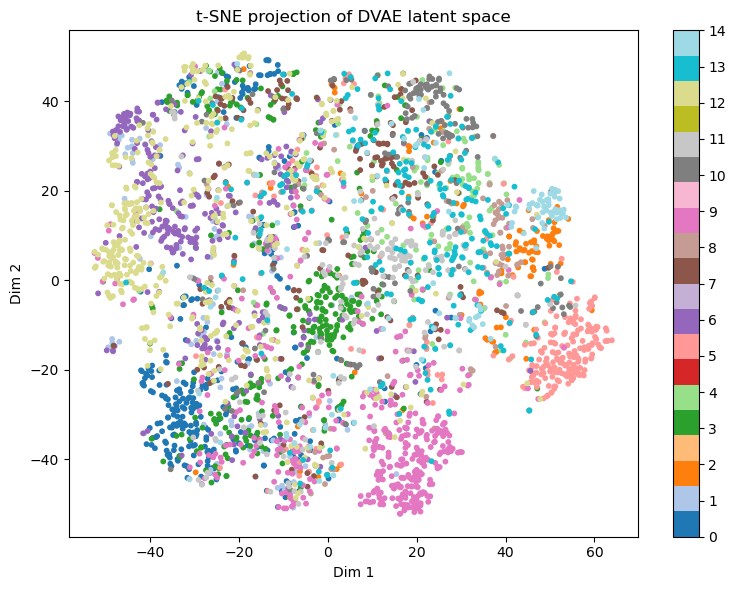

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Project the normalized latent vectors to 2D
zs_2d = TSNE(n_components=2, random_state=42).fit_transform(zs_normalized)

# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(zs_2d[:, 0], zs_2d[:, 1], c=ys, cmap='tab20', s=10)
plt.colorbar(scatter, ticks=range(len(set(ys))))
plt.title("t-SNE projection of DVAE latent space")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()


## MLP Classifier

In [ ]:

# Define MLP Classifier

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)



# Initialize and Train the MLP

input_dim = zs.shape[1]                     # Dimensionality of latent space
num_classes = len(le.classes_)              # Number of classes

mlp = MLPClassifier(input_dim=input_dim, num_classes=num_classes)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(1, 1001):
    mlp.train()
    logits = mlp(X_train)
    loss = loss_fn(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


[Epoch 1] Loss: 2.6686
[Epoch 50] Loss: 1.5575
[Epoch 100] Loss: 1.3866
[Epoch 150] Loss: 1.3220
[Epoch 200] Loss: 1.2761
[Epoch 250] Loss: 1.2298
[Epoch 300] Loss: 1.2089
[Epoch 350] Loss: 1.1607
[Epoch 400] Loss: 1.1079
[Epoch 450] Loss: 1.1059
[Epoch 500] Loss: 1.0763
[Epoch 550] Loss: 1.0356
[Epoch 600] Loss: 1.0283
[Epoch 650] Loss: 0.9894
[Epoch 700] Loss: 0.9651
[Epoch 750] Loss: 0.9481
[Epoch 800] Loss: 0.9117
[Epoch 850] Loss: 0.9065
[Epoch 900] Loss: 0.8841
[Epoch 950] Loss: 0.8554
[Epoch 1000] Loss: 0.8149


## Validation on Training Dataset

In [ ]:

# Evaluate on Validation Set

mlp.eval()
with torch.no_grad():
    preds = mlp(X_test).argmax(dim=1)
    acc = accuracy_score(y_test, preds)

print(f" Accuracy on validation set: {acc * 100:.2f}%")


 Accuracy on validation set: 57.89%


## Evaluate on test dataset

Test Set Accuracy: 50.51%


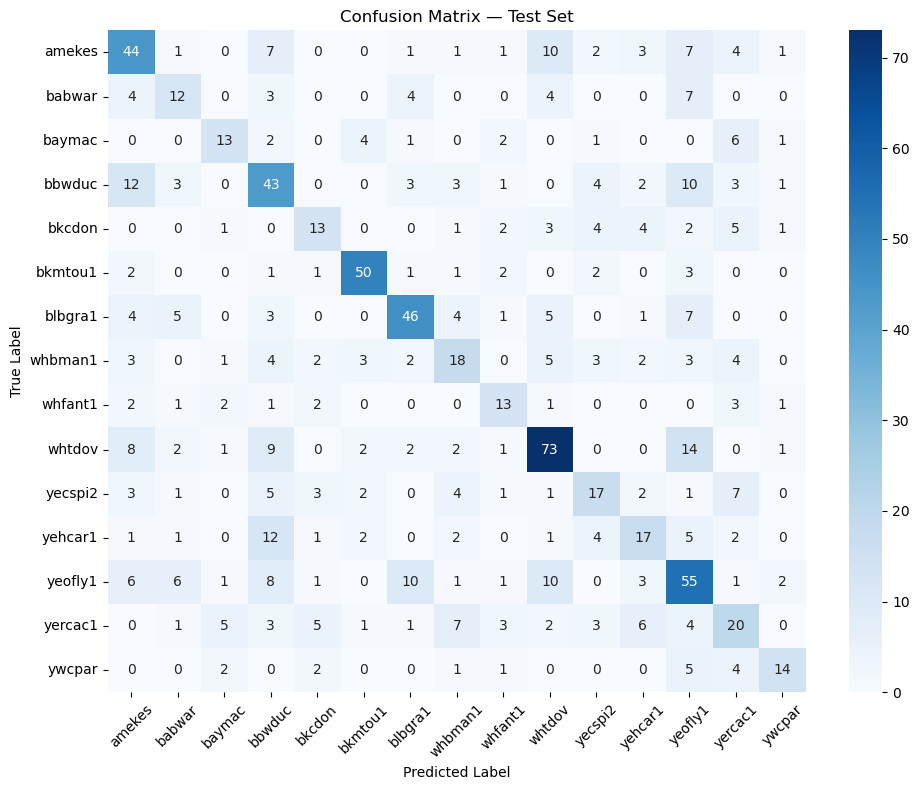

In [12]:
from pathlib import Path
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Define test set path
mfcc_test_root = Path.cwd() / "MFCC_Tensors_Test"

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Set models to eval mode
encoder.eval()
mlp.eval()

for class_dir in mfcc_test_root.iterdir():
    if not class_dir.is_dir():
        continue

    label_name = class_dir.name
    if label_name not in label_to_index:
        print(f"Skipping unknown class: {label_name}")
        continue

    true_label = label_to_index[label_name]
    mfcc_files = list(class_dir.glob("*.pt"))

    for f in tqdm(mfcc_files, desc=f"Testing {label_name}", leave=False):
        mfcc = torch.load(f)
        if mfcc.dim() == 3:
            mfcc = mfcc.squeeze(0)
        mfcc = mfcc.transpose(0, 1).unsqueeze(0)

        # Pad or crop to 100 time steps
        max_len = 100
        if mfcc.shape[1] < max_len:
            pad = torch.zeros((1, max_len - mfcc.shape[1], mfcc.shape[2]))
            mfcc = torch.cat([mfcc, pad], dim=1)
        else:
            mfcc = mfcc[:, :max_len, :]

        # Encode and classify
        with torch.no_grad():
            mu, _, _ = encoder(mfcc)
            z = (mu - zs_mean) / zs_std  # normalize using training stats
            logits = mlp(z)
            pred_label = logits.argmax(dim=1).item()

        y_true.append(true_label)
        y_pred.append(pred_label)

# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Set Accuracy: {acc * 100:.2f}%")

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
index_to_label = {v: k for k, v in label_to_index.items()}

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=index_to_label.values(),
            yticklabels=index_to_label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Loss Components Graph

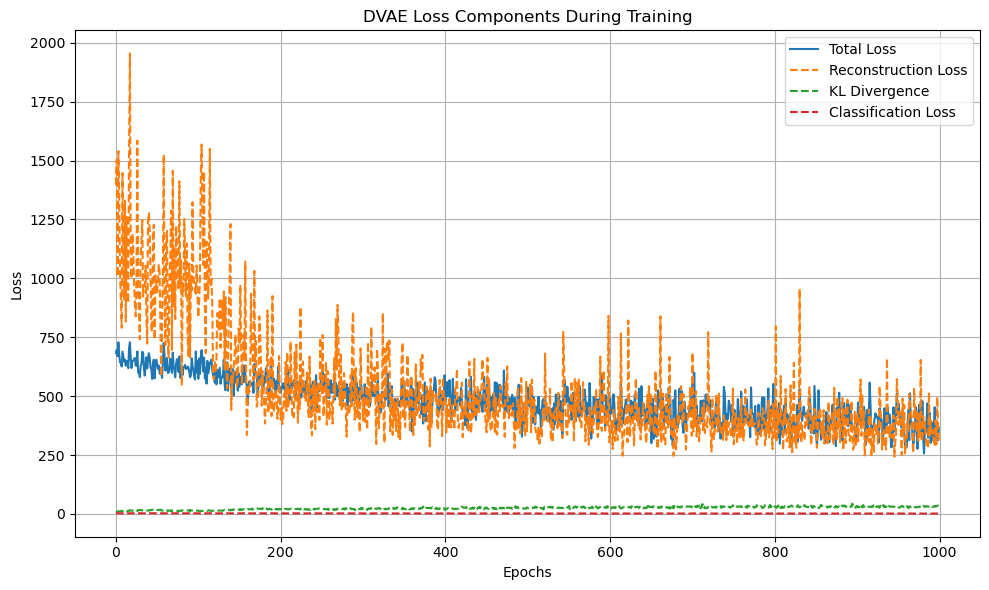

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history['total'], label='Total Loss')
plt.plot(history['recon'], label='Reconstruction Loss', linestyle='--')
plt.plot(history['kl'], label='KL Divergence', linestyle='--')
plt.plot(history['class'], label='Classification Loss', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DVAE Loss Components During Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# CNN 

Epoch 1 - Loss: 2.6040
Epoch 2 - Loss: 2.3899
Epoch 3 - Loss: 2.0859
Epoch 4 - Loss: 1.8456
Epoch 5 - Loss: 1.6490
Epoch 6 - Loss: 1.4809
Epoch 7 - Loss: 1.3371
Epoch 8 - Loss: 1.2378
Epoch 9 - Loss: 1.1539
Epoch 10 - Loss: 1.0526
Epoch 11 - Loss: 0.9817
Epoch 12 - Loss: 0.8997
Epoch 13 - Loss: 0.8537
Epoch 14 - Loss: 0.8139
Epoch 15 - Loss: 0.7161
Epoch 16 - Loss: 0.6811
Epoch 17 - Loss: 0.6358
Epoch 18 - Loss: 0.6056
Epoch 19 - Loss: 0.5490
Epoch 20 - Loss: 0.5082
Epoch 21 - Loss: 0.4844
Epoch 22 - Loss: 0.4618
Epoch 23 - Loss: 0.4039
Epoch 24 - Loss: 0.3801
Epoch 25 - Loss: 0.3733
Epoch 26 - Loss: 0.3242
Epoch 27 - Loss: 0.2982
Epoch 28 - Loss: 0.2853
Epoch 29 - Loss: 0.2655
Epoch 30 - Loss: 0.2528
Epoch 31 - Loss: 0.2243
Epoch 32 - Loss: 0.2039
Epoch 33 - Loss: 0.1910
Epoch 34 - Loss: 0.1919
Epoch 35 - Loss: 0.1824
Epoch 36 - Loss: 0.1677
Epoch 37 - Loss: 0.1704
Epoch 38 - Loss: 0.1527
Epoch 39 - Loss: 0.1586
Epoch 40 - Loss: 0.1489
Epoch 41 - Loss: 0.1439
Epoch 42 - Loss: 0.1443
E

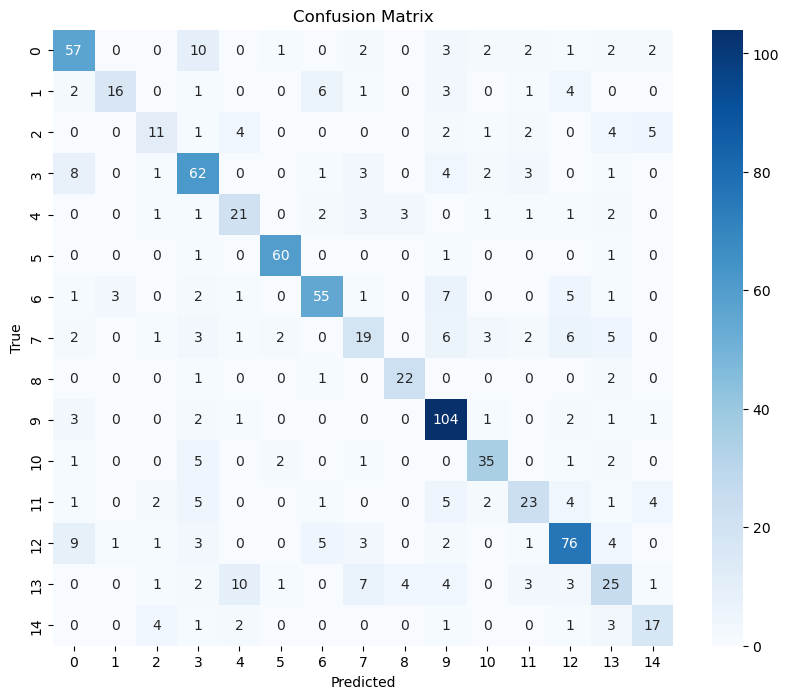

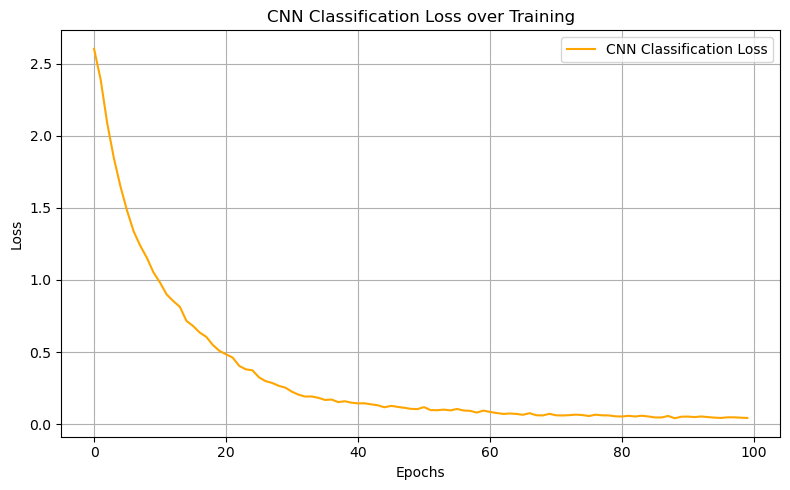

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- Dataset with Padding, Normalization, and Augmentation ---
class MFCC_CNN_Dataset(Dataset):
    def __init__(self, root_dir, max_len=400, augment=False):
        self.root_dir = Path(root_dir)
        self.samples = list(self.root_dir.rglob("*.pt"))
        self.label2idx = {
            label.name: idx for idx, label in enumerate(sorted(self.root_dir.iterdir())) if label.is_dir()
        }
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        mfcc = torch.load(path).squeeze(0)  # [13, T]

        if mfcc.shape[1] < self.max_len:
            pad = torch.zeros((13, self.max_len - mfcc.shape[1]))
            mfcc = torch.cat((mfcc, pad), dim=1)
        else:
            mfcc = mfcc[:, :self.max_len]

        # Normalize per frequency band
        mfcc = (mfcc - mfcc.mean(dim=1, keepdim=True)) / (mfcc.std(dim=1, keepdim=True) + 1e-6)

        if self.augment:
            if torch.rand(1).item() < 0.5:
                mfcc += 0.01 * torch.randn_like(mfcc)  # Gaussian noise
            if torch.rand(1).item() < 0.3:
                t = torch.randint(0, self.max_len - 10, (1,)).item()
                mfcc[:, t:t+10] = 0
            if torch.rand(1).item() < 0.3:
                f = torch.randint(0, 13 - 2, (1,)).item()
                mfcc[f:f+2, :] = 0

        mfcc = mfcc.unsqueeze(0)  # [1, 13, max_len]
        label = self.label2idx[path.parts[-2]]
        return mfcc.float(), torch.tensor(label)

# --- CNN Model ---
class CNNClassifier(nn.Module):
    def __init__(self, input_channels=1, n_mfcc=13, max_len=400, num_classes=15):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mfcc, max_len)
            out = self.pool(self.conv1(dummy))
            out = self.pool(self.conv2(out))
            out = self.pool(self.conv3(out))
            self.flat_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flat_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- Training Function ---
def train_full_model(train_dataset, test_dataset, model, device):
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    cnn_loss_history = []

    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        cnn_loss_history.append(avg_loss)
        print(f"Epoch {epoch} - Loss: {avg_loss:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            output = model(x)
            preds = output.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(y)

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc * 100:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
# loss function plot
    plt.figure(figsize=(8,5))
    plt.plot(cnn_loss_history, label="CNN Classification Loss", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("CNN Classification Loss over Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Main Execution ---
train_path = Path.cwd() / "MFCC_Tensors_Train"
test_path  = Path.cwd() / "MFCC_Tensors_Test"
max_len = 400
n_mfcc = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = MFCC_CNN_Dataset(train_path, max_len=max_len, augment=True)
test_dataset  = MFCC_CNN_Dataset(test_path,  max_len=max_len, augment=False)

model = CNNClassifier(n_mfcc=n_mfcc, max_len=max_len, num_classes=len(train_dataset.label2idx)).to(device)

train_full_model(train_dataset, test_dataset, model, device)
